In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Define global variables

In [63]:
time = 60  # set time limit for gurobi (12h*3600s/100=432s/round, so we pick 600s) 600s的话1h就跑完全部了

m = 50 # there are 50 X variables
M = 100  # set M to be large enough so that no value of beta is equal to M or -M
k_all = [5,10,15,20,25,30,35,40,45,50]

n = 10
kf = KFold(n_splits=n)

In [3]:
df_train = pd.read_csv('training_data.csv')
df_train[:5]

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [4]:
df_test = pd.read_csv('test_data.csv')
df_test[:5]

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [5]:
y_train = df_train['y'].to_numpy()
X_train = df_train.drop(['y'], axis=1).to_numpy()

In [6]:
y_test = df_test['y'].to_numpy()
X_test = df_test.drop(['y'], axis=1).to_numpy()

### Question 1: MIQP problem
#### Step 1: Set up MIQP Model

In [7]:
def beta(X, y, k):
    new_column = [1] * len(X)
    X_addConst = np.insert(X, 0, new_column, axis=1)
    
    # define quadratic term Q
    Q = np.zeros((2*m+1, 2*m+1))
    Q[0:m+1, 0:m+1] = np.transpose(X_addConst) @ X_addConst
    
    # define linear term c
    X_expand = np.zeros((len(X_addConst), 2*m+1))
    X_expand[0:len(X_addConst), 0:m+1] = X_addConst
    c = -2 * np.transpose(y) @ X_expand
    
    # define left hand side of constraint matrix A
    A = np.zeros((2*m+1, 2*m+1))
    A[:,0] = 0
    A[0:m, 1:m+1] = np.diag(np.ones(m))
    A[0:m, m+1:2*m+1] = np.diag(np.ones(m))*M
    A[m:2*m, 1:m+1] = np.diag(np.ones(m))
    A[m:2*m, m+1:2*m+1] = np.diag(np.ones(m))*(-M)
    A[2*m:2*m+1, m+1:2*m+1] = [1]*m
    
    # define right hand side of constraint matrix B
    b = np.array([0]*(2*m+1))
    b[-1] = k
    
    # define lower boundary lb
    lb = np.array([np.NINF] + [-M]*m + [np.NINF]*m)  # lb = np.array([-M] * (2*m+1))
    
    # define optimization sense
    sense = np.array(['>']*m + ['<']*(m+1))
    
    MIQPMod = gp.Model()
    MIQPMod_x = MIQPMod.addMVar(len(Q),lb=lb,vtype=['C']*(m+1)+['B']*m)
    MIQPMod_con = MIQPMod.addMConstrs(A, MIQPMod_x, sense, b)
    MIQPMod.setMObjective(Q,c,0,sense=gp.GRB.MINIMIZE)
    
    MIQPMod.Params.TimeLimit = time
    MIQPMod.optimize()
    
    coef = MIQPMod_x.x
    loss = MIQPMod.objVal
    
    return coef[0:m+1]

### Question 1: MIQP problem
#### Step 2: define a function to calculate sse

In [8]:
def least_squares(coef, X, y):
    new_column = [1] * len(X)
    X = np.insert(X, 0, new_column, axis=1)
    a = X @ coef - y
    b = np.transpose(a)
    c = b @ a
    return c

### Question 1: MIQP problem
#### Step 3: define a function to do cross validation

In [9]:
def cross_val(X, y, k):
    accuracies = []
    coefs = []
    df = pd.DataFrame(columns = ['coef'])
    df['coef'] = list(df_train.columns)
    i = 1
    for train_index, holdout_index in kf.split(X):
        X_train, X_holdout = X[train_index], X[holdout_index]
        y_train, y_holdout = y[train_index], y[holdout_index]
        coef = beta(X_train, y_train, k)
        sse = least_squares(coef, X_holdout, y_holdout)
        df[str(i)] = coef
        i = i+1
        accuracies.append(sse)
    sum_sse = sum(accuracies)
    df.set_index(['coef'],inplace=True)
    return sum_sse, df, accuracies

### Question 1: MIQP problem
#### Step 4: determine best k (k=10)

In [27]:
keys = []
values = []
coefs = []  # store each ten sets of coefficients for every k
accuracies = [] # store each ten sets of sse for every k
dict = {} # Store k and corresponding sse into dictionary
for k in k_all:
    sse, coef, acc = cross_val(X_train, y_train, k)
    keys.append(k)
    values.append(sse)
    coefs.append(coef)
    accuracies.append(acc)
dict['k'] = keys
dict['sse'] = values

df = pd.DataFrame(dict) # Convert dictionary into dataframe
best_result = df.loc[df['sse'].idxmin()] #find the best chosen k based on minimun sse

print('The best chosen k based on 10-folder cross validation is', best_result[0])
print('Corresponding sse is', best_result[1])

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x8bf840df
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [8e+00, 2e+03]
  QObjective range [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 9.000000e+20
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective -4.302233e+03, 424 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [ ]:
pd.DataFrame(accuracies).T.to_csv(r'C:\Users\Elisha\1. Optimization\Project 3\sse.csv',index = False)

In [ ]:
df1 = coefs[0].merge(coefs[1], left_on='coef', right_on='coef')
for i in range(2,10):
    df2 = df1.merge(coefs[i], left_on='coef', right_on='coef')
    df1 = df2

In [50]:
df2.to_csv(r'C:\Users\Elisha\1. Optimization\Project 3\coefficients.csv',index = False)

### Question 1: MIQP problem
#### Step 4: fit the MIQP model on the entire training with k=10

In [33]:
coefficient = beta(X_train, y_train, 10)

Academic license - for non-commercial use only - expires 2022-01-01
Using license file C:\Users\Elisha\gurobi.lic
Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0xcd886e69
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 1.000000e+21
Presolve time: 0.02s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective -4.799511e+03, 351 iterations

In [34]:
coefficient

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

### Question 1: MIQP problem
#### Step 5: make a prediction of the y values in the test set.

In [35]:
X_test_cst = np.insert(X_test, 0, [1] * len(X_test), axis=1)

In [36]:
X_test_cst @ coefficient

array([ 6.17985878,  5.09524299,  3.28559532,  3.75848539, -0.33297526,
       -5.14273683, -3.14454357, -1.23806288,  1.38511093, -0.44173854,
       -1.69500225,  2.73035027,  0.74744903, -0.97192232, -0.68681528,
        8.04522381, -7.94698471,  3.89063974, -4.58142919, -3.21992082,
       -2.16211454,  3.21686318, -3.19810533,  0.19740731, -2.35988844,
       -0.41999885, -1.9125216 , -3.32418587, -3.14170972, -3.55379324,
       -1.80842543, -0.37134301,  1.8670808 ,  5.04927886, -1.80005614,
        3.09427675,  4.38154309,  2.6988627 ,  1.6132886 ,  5.97584637,
       -1.1973583 ,  5.2232542 , -5.84899891, -1.14461528,  4.51802998,
        4.18774866,  4.12046008,  0.61483809,  1.95723246, -1.54904383])

In [37]:
sse_miqp_pred = sum((y_test - X_test_cst @ coefficient)**2)  # sse
sse_miqp_pred

116.82719822762623

In [38]:
mse_miqp_pred = mean_squared_error(y_test, X_test_cst @ coefficient) # mse
mse_miqp_pred

2.336543964552525

### Question 2: Indirect Variable Selection – LASSO
#### Step 1: use scikit learn to do 10-fold cross validation on the training set to pick lambda.

In [43]:
# Write function that computes the sse over all 10 folds for lasso.
def cv_accuracy_score_lasso(X, y, alpha):
    model = Lasso(alpha=alpha)
    accuracies = []
    for train_index, holdout_index in kf.split(X):
        X_train, X_holdout = X[train_index], X[holdout_index]
        y_train, y_holdout = y[train_index], y[holdout_index]
    
        model.fit(X_train, y_train) # Fit the model
        
        #mse = mean_squared_error(y_holdout, model.predict(X_holdout)) # mse: average of squared error
        sse = sum((y_holdout-model.predict(X_holdout))**2) # sse: sum of squared error
        accuracies.append(sse)
    
    sum_sse = sum(accuracies)
    return sum_sse

In [44]:
alphas = 10**np.linspace(3,-3,100) # Generate 100 uniform values between -3 to 3 as power series

In [45]:
keys = []
values = []
dict = {} # Store alpha and corresponding sse into dictionary
for alpha in alphas:
    keys.append(alpha)
    values.append(cv_accuracy_score_lasso(X_train, y_train, alpha))
    
dict['alpha_value'] = keys
dict['sse_value'] = values

df_lr = pd.DataFrame(dict) # Convert dictionary into dataframe
best_alpha = df_lr.loc[df_lr['sse_value'].idxmin()] #find the best chosen alpha based on minimun sse

print('The best chosen alpha based on 10-folder cross validation is', best_alpha[0])
print('Corresponding sse is', best_alpha[1])

The best chosen alpha based on 10-folder cross validation is 0.07564633275546291
Corresponding sse is 695.0009716402944


In [42]:
# use GridSearchCV for cross check
parameters = {'alpha': (10**np.linspace(3,-3,100)).tolist()}
lassoLR = Lasso()
cv = GridSearchCV(lassoLR, parameters, cv=10)
cv.fit(X_train, y_train)

cv.best_params_

{'alpha': 0.07564633275546291}

### Question 2: Indirect Variable Selection – LASSO
#### Step 2: fit a LASSO model to the entire training set using best value of lambda.

In [43]:
model = Lasso(alpha=best_alpha[0])
model.fit(X_train, y_train)
model.intercept_

1.0012560321193624

In [44]:
model.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16147919,  0.        ,
       -0.06028991, -0.        , -0.        , -0.        , -0.41930777,
       -0.19337138,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19501545, -1.36447134,  0.74326223, -0.        ,
       -1.30502792, -0.        ,  0.        ,  0.05772294,  0.        ,
       -0.        ,  0.        , -0.09750849,  0.284521  ,  0.        ,
        0.        ,  0.        ,  0.        , -0.23263118,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03158515,  1.56441478,
       -0.0224679 ,  0.70137679, -0.09332704,  0.        ,  0.        ])

### Question 2: Indirect Variable Selection – LASSO
#### Step 3: use LASSO model make a prediction of the y values in the test set.

In [45]:
model.predict(X_test)

array([ 6.07920695,  4.91821176,  3.22938558,  3.57269902, -0.41887608,
       -4.95279151, -2.82253586, -1.49669292,  1.38204396, -0.24649558,
       -1.94669224,  2.70686311,  0.64573778, -0.50742459, -0.31804099,
        7.38066696, -7.5512808 ,  3.59346235, -4.39515901, -2.98833238,
       -1.94391142,  3.33048512, -2.42365248,  1.13284388, -2.53660637,
       -0.1548456 , -1.62646119, -2.31765893, -3.4659375 , -3.71779758,
       -1.66893203, -0.07897655,  1.40503668,  5.45240041, -1.2039636 ,
        2.37264021,  4.74896634,  3.12898857,  1.55096086,  5.85525208,
       -0.81404428,  4.66488981, -5.71830719, -1.21112084,  4.25440206,
        4.09879276,  3.83181804,  0.61678184,  1.89303431, -1.02668652])

In [46]:
mse_lasso_pred = mean_squared_error(y_test, model.predict(X_test))
mse_lasso_pred

2.3493758081184866

In [49]:
sse_lasso_pred = sum((y_test-model.predict(X_test))**2)
sse_lasso_pred

117.46879040592432

### Question 3: Visualization for conclusion
#### 1. In-Sample SSE

In [39]:
sse = pd.read_csv('sse.csv')
output_df_miqp = pd.DataFrame(columns = ['k', 'cross_val_sse'])
output_df_miqp['k'] = k_all
output_df_miqp['cross_val_sse'] = sse.sum().tolist()
output_df_miqp.T.astype(int)

,0,1,2,3,4,5,6,7,8,9
k,5,10,15,20,25,30,35,40,45,50
cross_val_sse,917,724,764,799,770,830,831,847,843,847


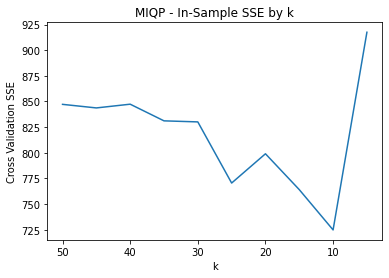

In [71]:
ax = plt.gca()

ax.plot(output_df_miqp['k'], output_df_miqp['cross_val_sse'])
ax.set_xlim(55, 0)
plt.xlabel('k')
plt.ylabel('Cross Validation SSE')
plt.title('MIQP - In-Sample SSE by k')
plt.axis('tight')
plt.show()

In [46]:
df_lr

,alpha_value,sse_value
0,1000.000000,4943.255428
1,869.749003,4943.255428
2,756.463328,4943.255428
3,657.933225,4943.255428
4,572.236766,4943.255428
...,...,...
95,0.001748,828.351997
96,0.001520,831.164829
97,0.001322,833.784620
98,0.001150,835.671935


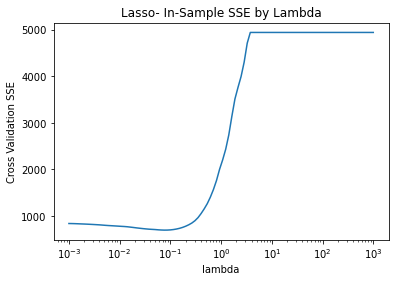

In [55]:
ax = plt.gca()

ax.plot(df_lr['alpha_value'], df_lr['sse_value'])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])
plt.xlabel('lambda')
plt.ylabel('Cross Validation SSE')
plt.title('Lasso- In-Sample SSE by Lambda')
plt.axis('tight')
plt.show()

#### 2. Out-of-Sample SSE

In [68]:
out_of_sample = pd.DataFrame(columns = ['method', 'sse'])
out_of_sample['method'] = ['MIQP', 'Lasso']
out_of_sample['sse'] = [sse_miqp_pred, sse_lasso_pred]
out_of_sample.set_index('method',inplace=True)
out_of_sample

,sse
method,
MIQP,116.827198
Lasso,117.468790


<AxesSubplot:xlabel='method'>

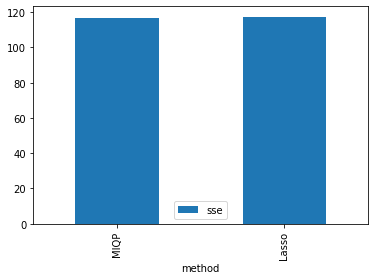

In [69]:
out_of_sample.plot(kind='bar')

#### 3. Plot the coefficients learned for all of the alpha in lasso

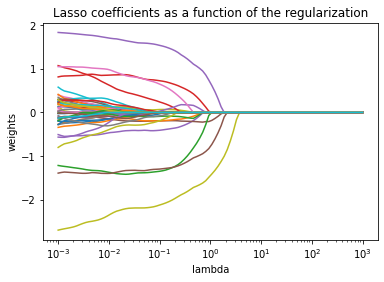

In [48]:
# Plot the coefficients learned for all of the alpha in lasso
coefs = []
for alpha in alphas:
    model = Lasso(alpha)
    model.fit(X_train, y_train) # Fit the model
    coefs.append(model.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::1])
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

#### 4. Plot the coefficients learned for all of the k in MIQP

In [64]:
coefs = []
for k in k_all:
    coefficient = beta(X_train, y_train, k)
    coefs.append(coefficient)

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 101 rows, 101 columns and 250 nonzeros
Model fingerprint: 0x1631b958
Model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e+01, 2e+03]
  QObjective range [3e-02, 8e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 1.000000e+21
Presolve time: 0.00s
Presolved: 101 rows, 101 columns, 250 nonzeros
Presolved model has 1326 quadratic objective terms
Variable types: 51 continuous, 50 integer (50 binary)

Root relaxation: objective -4.799511e+03, 423 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

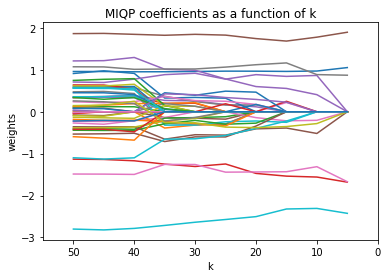

In [70]:
ax = plt.gca()

ax.plot(np.asarray(k_all), coefs)
ax.set_xlim(55, 0)
plt.xlabel('k')
plt.ylabel('weights')
plt.title('MIQP coefficients as a function of k')
plt.show()